## Imports

In [150]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.filters
import scipy.stats

## Spine detection

In [151]:
def plot_img(img, show = True):
    
    fig = plt.figure(figsize = (12,12))
    plt.imshow(img, cmap = 'gray', interpolation = 'none')
    
    if show:
        plt.show()
        
def plot_hist(img, show = True):
    plt.hist(img.flatten(), bins = 100)
    
    if show:
        plt.show()

downsample 0


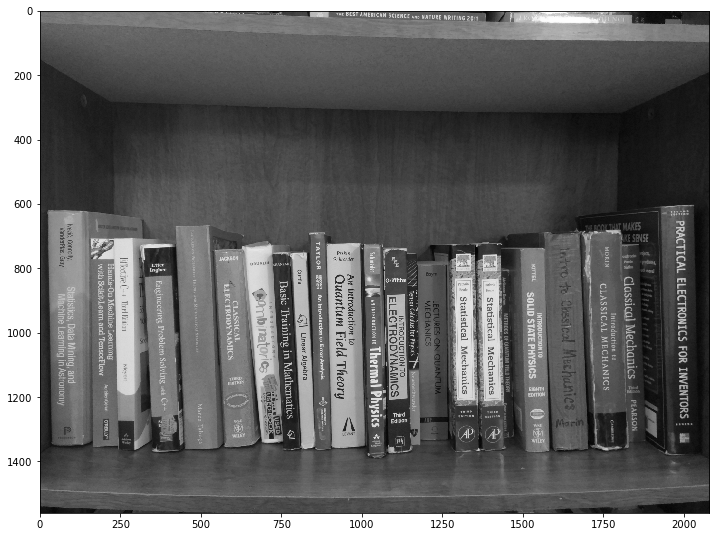

downsample 1


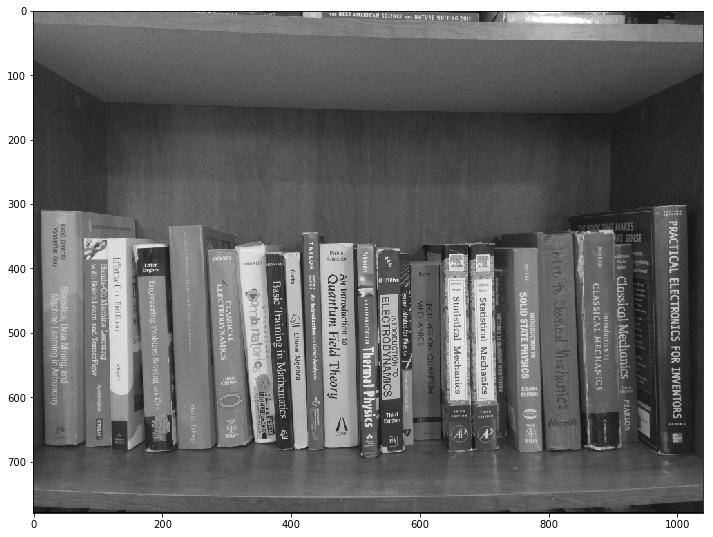

downsample 2


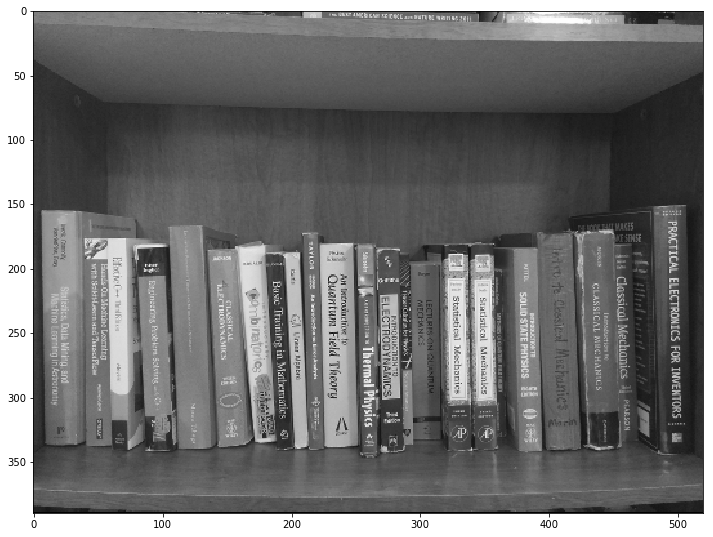

sobel x


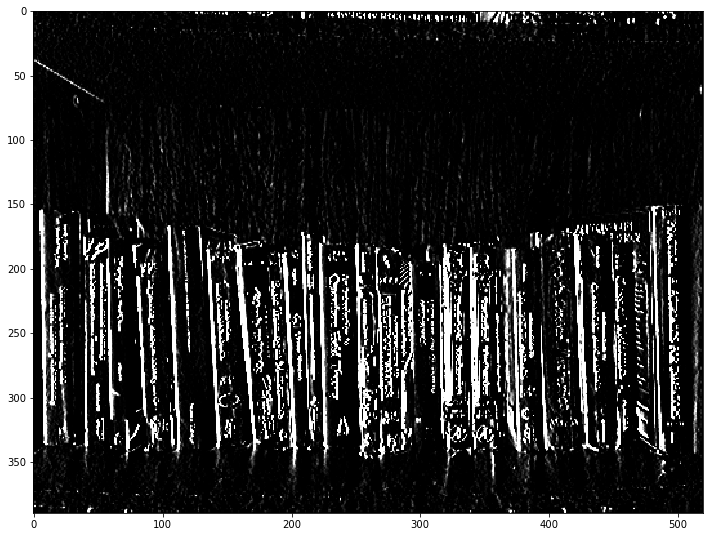

standardize


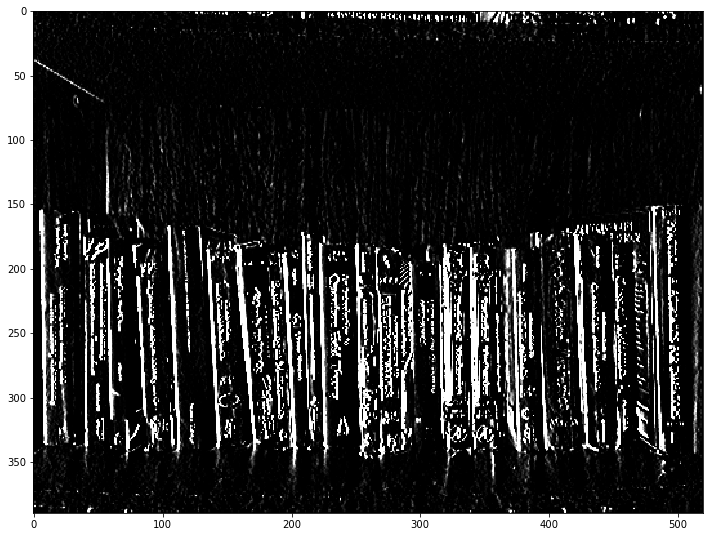

digitize


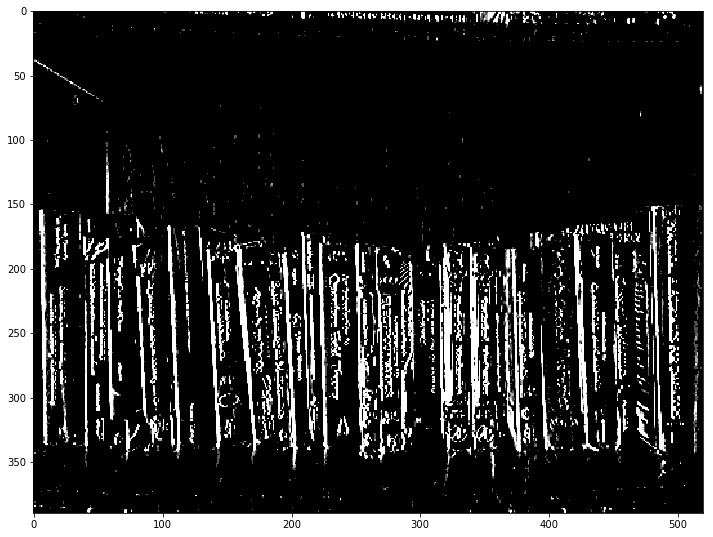

binarize


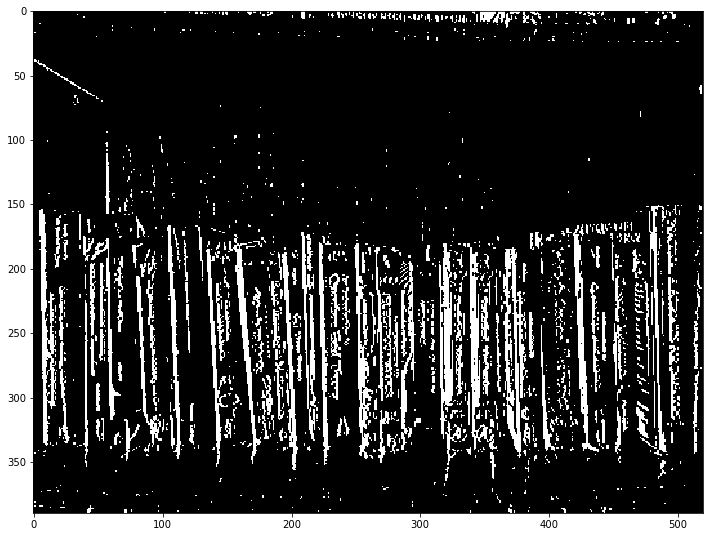

erode/subtract


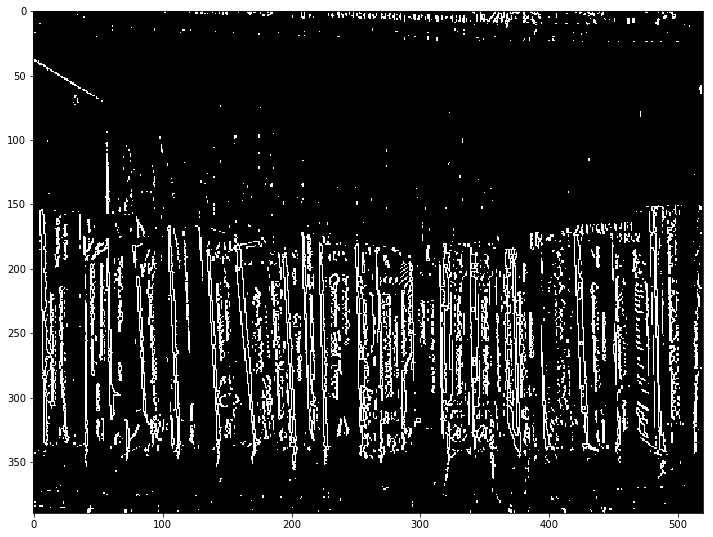

morpho erode


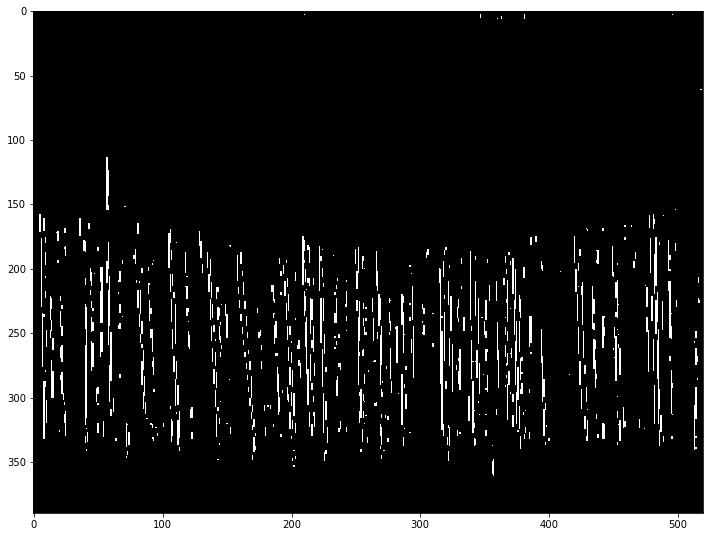

morpho dilate


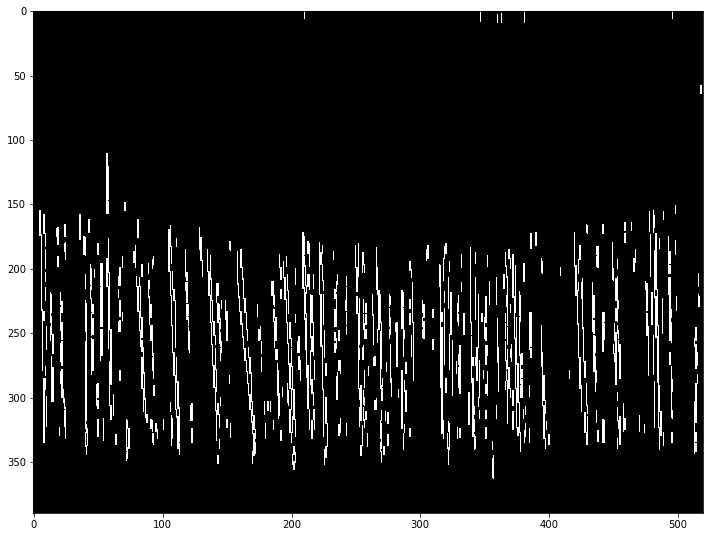

Digitize


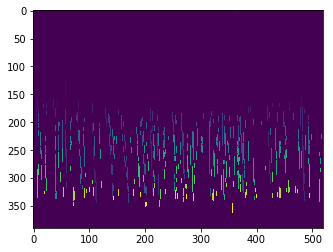

Remove clusters that are too small


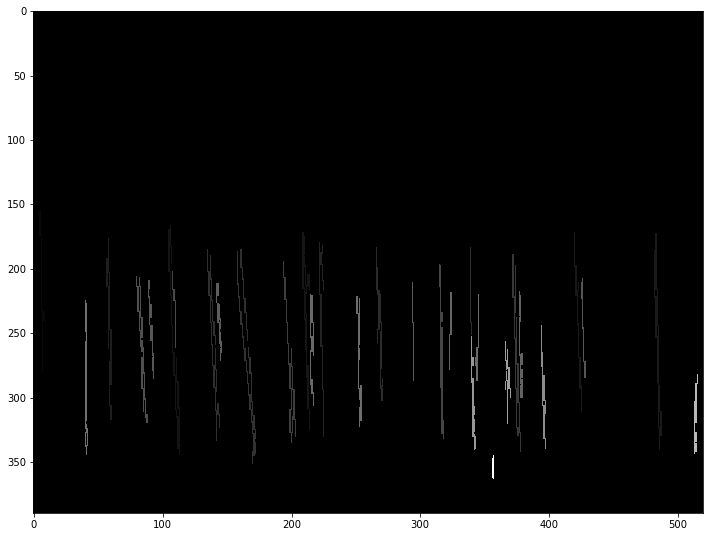

Binarize


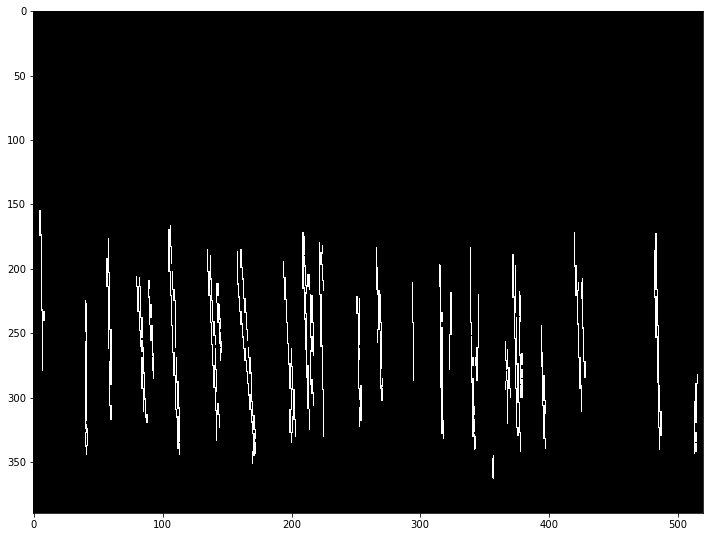

morpho dilate


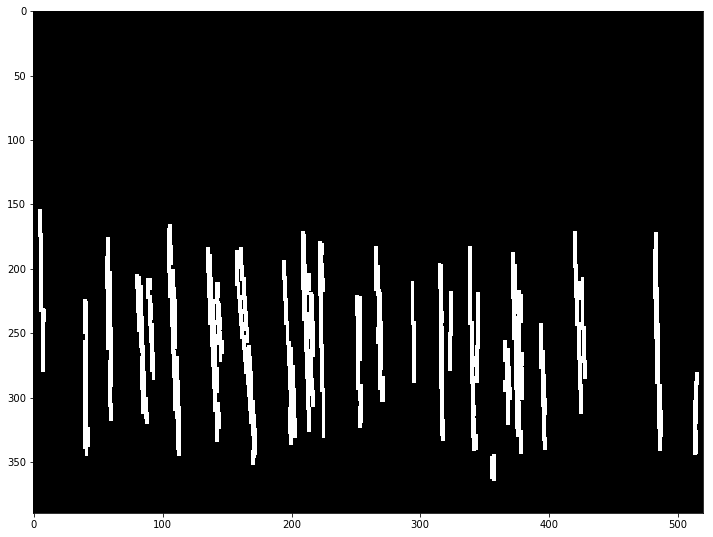

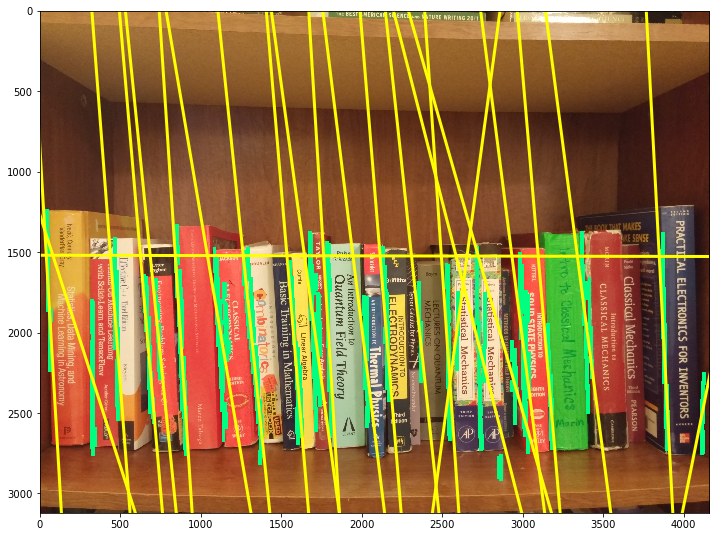

In [175]:
file_directory = '/home/prestonh/Desktop/Programming/datasci/insight/projects/shelfy/shelfy/data/shelves/home_2/'
file_name = 'home_2.jpg'
file_path = file_directory + file_name

img = cv2.imread(file_path)




debug = True

# Copy
proc_img = np.mean(img[:,:], axis = 2).astype(np.uint8)


# Down sample
num_downsamples = 3
for i in range(num_downsamples):
    proc_img = scipy.ndimage.interpolation.zoom(proc_img,.5)

    if debug:
        print('downsample', i)
        plot_img(proc_img, show = True)



## Sobel x
proc_img = cv2.Sobel(proc_img, cv2.CV_8UC1, 1, 0, ksize = -1)**2.


if debug:
    print('sobel x')
    plot_img(proc_img)



# Standardize
proc_img = (proc_img - np.min(proc_img))/np.max(proc_img)

if debug:
    print('standardize')
    plot_img(proc_img)


# Digitize
img_max = np.max(proc_img)
img_min = np.min(proc_img)
num_levels = 4
bins = [1.*i*(img_max-img_min)/num_levels for i in range(0, num_levels)]
proc_img = np.digitize(proc_img, bins)

if debug:
    print('digitize')
    plot_img(proc_img, show = True)



# Binarize
proc_img[proc_img == np.min(proc_img)] = 0
proc_img[proc_img != 0] = 1


if debug:
    print('binarize')
    plot_img(proc_img, show = True)


# Horizontal erosion and subtraction
for i in range(1):
    structure_length = 5*(i+1)
    #structure = np.ones((3,3))*structure_length
    structure = np.ones((3,3))*structure_length
    old_proc_img = np.copy(proc_img)
    proc_img = proc_img - scipy.ndimage.morphology.binary_erosion(proc_img, structure, 1)

    if debug:
        print('erode/subtract')
        plot_img(proc_img, show = True)


# Vertical erode
for i in range(1):
    structure_length = 200
    #structure = np.array([[0,1,0],[0,1,0],[0,1,0]])*structure_length
    structure = np.array([[0,1,0],[0,1,0],[0,1,0]])*structure_length
    proc_img = scipy.ndimage.morphology.binary_erosion(proc_img, structure, 3)

    if debug:
        print('morpho erode')
        plot_img(proc_img, show = True)

# Vertical dilate
for i in range(1):
    structure_length = 3
    #structure = np.array([[0,1,0],[0,1,0],[0,1,0]])*structure_length
    structure = np.array([[0,1,0],[0,1,0],[0,1,0]])*structure_length
    proc_img = scipy.ndimage.morphology.binary_dilation(proc_img, structure, 3)

    if debug:
        print('morpho dilate')
        plot_img(proc_img, show = True)





# Connected components
proc_img, unique_values = scipy.ndimage.label(proc_img, structure = np.ones((3,3)))

unique_values = list(range(unique_values))





if debug:
    print('Digitize')
    plt.imshow(proc_img)
    plt.show()
    
    
# Remove clusters too small
drop_values = []
threshold = proc_img.shape[0]*.15
for unique_value in unique_values:
    bright_pixels = np.where(proc_img == unique_value)
    ptp = np.ptp(bright_pixels[0])



    if(ptp < threshold):
        drop_values.append(unique_value)

for drop_value in drop_values:
    proc_img[proc_img == drop_value] = 0

if debug:
    print('Remove clusters that are too small')
    plot_img(proc_img, show = True)


# Re-binarize
proc_img[proc_img != 0] = 1

if debug:
    print('Binarize')
    plot_img(proc_img, show = True)


# Horizontal dilate
for i in range(1):
    structure_length = 3
    structure = np.array([[1,1,1],[1,1,1],[1,1,1]])*structure_length
    proc_img = scipy.ndimage.morphology.binary_dilation(proc_img, structure, 1)

    if debug:
        print('morpho dilate')
        plot_img(proc_img, show = True)


# Up sample
proc_img = proc_img.repeat(8, axis = 0).repeat(8, axis = 1)


# Connected components
proc_img, unique_values = scipy.ndimage.label(proc_img, structure = np.ones((3,3)))
unique_values = list(range(unique_values))

# Lines
ms = []
bs = []
for unique_value in unique_values:
    line = np.where(proc_img == unique_value)
    xs = line[1]
    ys = line[0]


    m, b, r, p, std = scipy.stats.linregress(xs,ys)
    ms.append(m)
    bs.append(b)





new_img = np.copy(img[:,:,::-1])
new_img[proc_img != 0,:] = [0,255,128]



plot_img(new_img, show = False)

for i in range(len(ms)):
    y0 = 0
    y1 = new_img.shape[0]
    x0 = (y0-bs[i])/ms[i]
    x1 = (y1-bs[i])/ms[i]
    
    plt.plot([x0,x1],[y0,y1], c = 'yellow', lw = 3)
    
plt.xlim(0, new_img.shape[1])
plt.ylim(new_img.shape[0], 0)

plt.show()





[-0.00058848128426302346, 10.617026355127534, 26.838039985225951, 36.912471989753925, -13.496756484825568, 17.406110905796783, -15.986245338172708, -19.319422289790126, -19.239750398624679, -17.800845952053901, 16.729367036125332] [1562.39796104027, -5984.9733600779464, -3996.7372207972644, -12424.636507859666, 30267.423073081591, -11196.486591843972, 46465.349602821669, 38136.255560493009, 29703.04724571011, 35935.981393649847, -6770.322637911022]


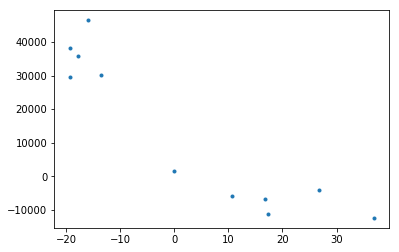

In [167]:
print(ms, bs)
plt.scatter(ms, bs, marker = '.')
plt.show()